In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# mlxtend for association rule mining
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules

sns.set(style='whitegrid')
pd.set_option('display.max_columns', 200)

In [2]:
# Step 1: Load the CSV dataset directly from UCI
url = "https://raw.githubusercontent.com/dbdmg/data-science-lab/master/datasets/online_retail.csv"
df_raw = pd.read_csv(url, encoding='latin1')
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
# Step 2: Data cleaning
df = df_raw.dropna(subset=['InvoiceNo', 'Description'])
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]  # Remove cancelled transactions
df['Description'] = df['Description'].str.strip().str.lower()
df = df[df['Description'].str.len() > 2]

# Group items by transaction (InvoiceNo)
transactions = df.groupby('InvoiceNo')['Description'].apply(list).tolist()
print("Number of transactions:", len(transactions))

Number of transactions: 20556


In [4]:
min_item_freq = 5
item_counts = Counter(item for trx in transactions for item in trx)
frequent_items = {item for item, cnt in item_counts.items() if cnt >= min_item_freq}

transactions_pruned = [[it for it in trx if it in frequent_items] for trx in transactions]
transactions_pruned = [trx for trx in transactions_pruned if len(trx) > 0]
print("Transactions after pruning:", len(transactions_pruned))

Transactions after pruning: 20347


In [5]:
# Step 3: One-hot encode transactions
te = TransactionEncoder()
te_ary = te.fit(transactions_pruned).transform(transactions_pruned, sparse=False)
df_onehot = pd.DataFrame(te_ary, columns=te.columns_)
df_onehot.shape

(20347, 3537)

In [6]:
# Step 4: Frequent itemsets using Apriori
min_support = 0.01
start = time.time()
freq_apriori = apriori(df_onehot, min_support=min_support, use_colnames=True)
apriori_time = time.time() - start
freq_apriori['length'] = freq_apriori['itemsets'].apply(lambda x: len(x))
print("Apriori runtime (s):", apriori_time)
freq_apriori.sort_values(['support','length'], ascending=[False, True]).head(10)

Apriori runtime (s): 277.1615161895752


,support,itemsets,length
764,0.111073,(white hanging heart t-light holder),1
336,0.102816,(jumbo bag red retrospot),1
544,0.097754,(regency cakestand 3 tier),1
452,0.082862,(party bunting),1
376,0.076866,(lunch bag red retrospot),1
45,0.071509,(assorted colour bird ornament),1
613,0.068069,(set of 3 cake tins pantry design),1
432,0.064874,(pack of 72 retrospot cake cases),1
368,0.062565,(lunch bag black skull.),1
406,0.061385,(natural slate heart chalkboard),1


In [7]:
# Step 5: Frequent itemsets using FP-Growth
start = time.time()
freq_fpgrowth = fpgrowth(df_onehot, min_support=min_support, use_colnames=True)
fpgrowth_time = time.time() - start
freq_fpgrowth['length'] = freq_fpgrowth['itemsets'].apply(lambda x: len(x))
print("FP-Growth runtime (s):", fpgrowth_time)
freq_fpgrowth.sort_values(['support','length'], ascending=[False, True]).head(10)

FP-Growth runtime (s): 96.1478979587555


,support,itemsets,length
0,0.111073,(white hanging heart t-light holder),1
92,0.102816,(jumbo bag red retrospot),1
297,0.097754,(regency cakestand 3 tier),1
584,0.082862,(party bunting),1
42,0.076866,(lunch bag red retrospot),1
7,0.071509,(assorted colour bird ornament),1
614,0.068069,(set of 3 cake tins pantry design),1
43,0.064874,(pack of 72 retrospot cake cases),1
174,0.062565,(lunch bag black skull.),1
79,0.061385,(natural slate heart chalkboard),1


In [8]:
# Step 6: Generate association rules
min_confidence = 0.4

rules_apriori = association_rules(freq_apriori, metric="confidence", min_threshold=min_confidence)
rules_apriori = rules_apriori.sort_values(['confidence','lift'], ascending=[False, False])
rules_apriori.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
556,"(suki shoulder bag, jam making set printed)",(dotcom postage),0.010714,0.034796,0.010272,0.958716,27.552240,1.0,0.009899,23.379379,0.974142,0.291492,0.957227,0.626957
1023,"(regency tea plate pink, regency tea plate roses)",(regency tea plate green),0.013221,0.018725,0.012533,0.947955,50.624799,1.0,0.012285,18.854496,0.993380,0.645570,0.946962,0.808623
182,(herb marker thyme),(herb marker rosemary),0.011648,0.011795,0.010862,0.932489,79.055679,1.0,0.010724,14.637781,0.998987,0.863281,0.931684,0.926661
1041,"(wooden tree christmas scandinavian, wooden he...",(wooden star christmas scandinavian),0.012238,0.025163,0.011353,0.927711,36.867446,1.0,0.011045,13.485239,0.984929,0.435849,0.925845,0.689441
181,(herb marker rosemary),(herb marker thyme),0.011795,0.011648,0.010862,0.920833,79.055679,1.0,0.010724,12.484447,0.999136,0.863281,0.919900,0.926661
1078,"(woodland charlotte bag, charlotte bag pink po...",(red retrospot charlotte bag),0.012926,0.050818,0.011894,0.920152,18.106707,1.0,0.011237,11.887371,0.957144,0.229384,0.915877,0.577097
1174,"(woodland charlotte bag, charlotte bag pink po...",(red retrospot charlotte bag),0.010911,0.050818,0.010026,0.918919,18.082440,1.0,0.009472,11.706574,0.955119,0.193916,0.914578,0.558105
1022,"(regency tea plate pink, regency tea plate green)",(regency tea plate roses),0.013663,0.021871,0.012533,0.917266,41.940708,1.0,0.012234,11.822608,0.989679,0.544872,0.915416,0.745150
387,(regency tea plate pink),(regency tea plate green),0.014990,0.018725,0.013663,0.911475,48.676615,1.0,0.013382,11.084772,0.994362,0.681373,0.909786,0.820567
1098,"(regency cakestand 3 tier, roses regency teacu...",(green regency teacup and saucer),0.016268,0.049885,0.014793,0.909366,18.229420,1.0,0.013982,10.482941,0.960773,0.288038,0.904607,0.602959


In [9]:
rules_fpgrowth = association_rules(freq_fpgrowth, metric="confidence", min_threshold=min_confidence)
rules_fpgrowth = rules_fpgrowth.sort_values(['confidence','lift'], ascending=[False, False])
rules_fpgrowth.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
804,"(suki shoulder bag, jam making set printed)",(dotcom postage),0.010714,0.034796,0.010272,0.958716,27.552240,1.0,0.009899,23.379379,0.974142,0.291492,0.957227,0.626957
1157,"(regency tea plate pink, regency tea plate roses)",(regency tea plate green),0.013221,0.018725,0.012533,0.947955,50.624799,1.0,0.012285,18.854496,0.993380,0.645570,0.946962,0.808623
533,(herb marker thyme),(herb marker rosemary),0.011648,0.011795,0.010862,0.932489,79.055679,1.0,0.010724,14.637781,0.998987,0.863281,0.931684,0.926661
826,"(wooden tree christmas scandinavian, wooden he...",(wooden star christmas scandinavian),0.012238,0.025163,0.011353,0.927711,36.867446,1.0,0.011045,13.485239,0.984929,0.435849,0.925845,0.689441
532,(herb marker rosemary),(herb marker thyme),0.011795,0.011648,0.010862,0.920833,79.055679,1.0,0.010724,12.484447,0.999136,0.863281,0.919900,0.926661
148,"(woodland charlotte bag, charlotte bag pink po...",(red retrospot charlotte bag),0.012926,0.050818,0.011894,0.920152,18.106707,1.0,0.011237,11.887371,0.957144,0.229384,0.915877,0.577097
171,"(woodland charlotte bag, charlotte bag pink po...",(red retrospot charlotte bag),0.010911,0.050818,0.010026,0.918919,18.082440,1.0,0.009472,11.706574,0.955119,0.193916,0.914578,0.558105
1156,"(regency tea plate pink, regency tea plate green)",(regency tea plate roses),0.013663,0.021871,0.012533,0.917266,41.940708,1.0,0.012234,11.822608,0.989679,0.544872,0.915416,0.745150
1152,(regency tea plate pink),(regency tea plate green),0.014990,0.018725,0.013663,0.911475,48.676615,1.0,0.013382,11.084772,0.994362,0.681373,0.909786,0.820567
908,"(regency cakestand 3 tier, roses regency teacu...",(green regency teacup and saucer),0.016268,0.049885,0.014793,0.909366,18.229420,1.0,0.013982,10.482941,0.960773,0.288038,0.904607,0.602959


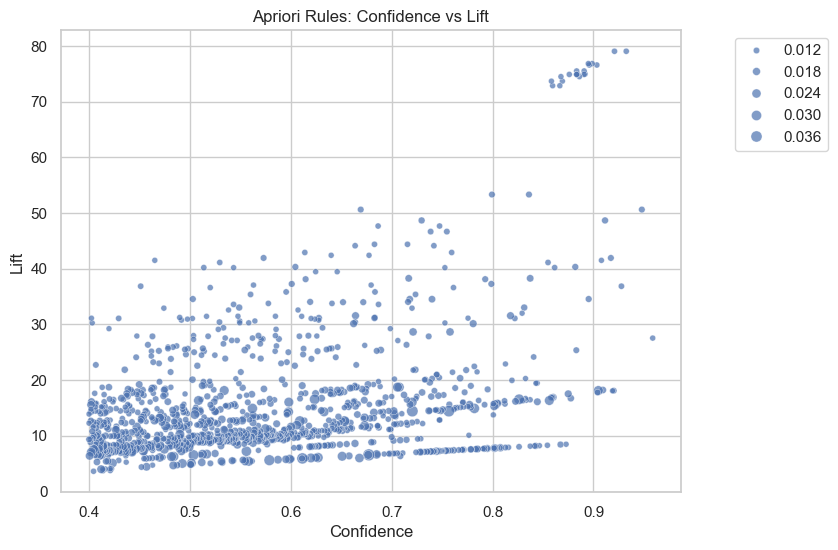

In [10]:
# Step 7: Visualizations
plt.figure(figsize=(8,6))
sns.scatterplot(x='confidence', y='lift', size='support', data=rules_apriori, alpha=0.7)
plt.title('Apriori Rules: Confidence vs Lift')
plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.show()

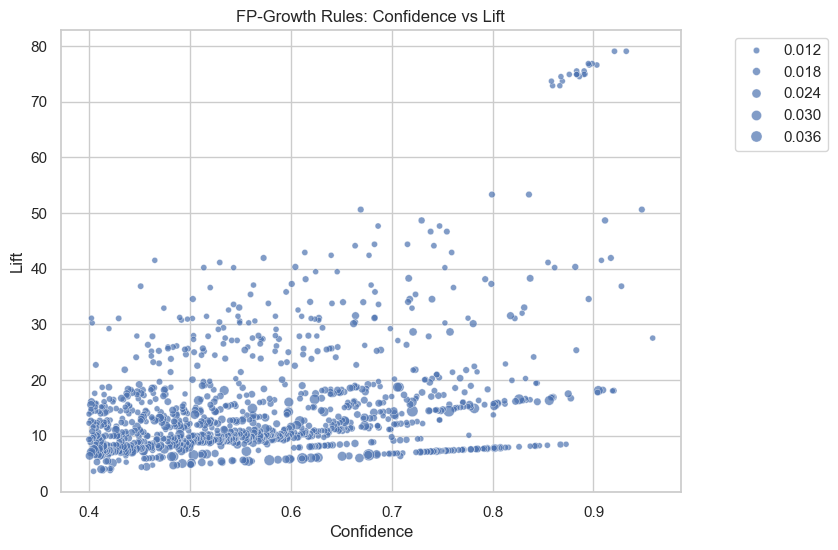

In [11]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='confidence', y='lift', size='support', data=rules_fpgrowth, alpha=0.7)
plt.title('FP-Growth Rules: Confidence vs Lift')
plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.show()

In [12]:
# Step 8: Compare Apriori vs FP-Growth
print("Apriori itemsets:", len(freq_apriori), "| Apriori rules:", len(rules_apriori))
print("FP-Growth itemsets:", len(freq_fpgrowth), "| FP-Growth rules:", len(rules_fpgrowth))

Apriori itemsets: 1812 | Apriori rules: 1194
FP-Growth itemsets: 1812 | FP-Growth rules: 1194


In [13]:
# Step 9: Save results
freq_apriori.to_csv('apriori_itemsets.csv', index=False)
freq_fpgrowth.to_csv('fpgrowth_itemsets.csv', index=False)
rules_apriori.to_csv('apriori_rules.csv', index=False)
rules_fpgrowth.to_csv('fpgrowth_rules.csv', index=False)
print("Saved CSV outputs.")

Saved CSV outputs.
